In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler

In [98]:
df_model = pd.read_csv("analysis_data.csv")
df_model.head()

,locality_name,region_name,price,value_per_sqft,area,construction_status,house_type,total_rooms,total_beds,new_resale,age
0,Tarwala Nagar,Nashik,8499000.0,3761,2260,Under Construction,Apartment,6,4,New,-1.0
1,Dombivali,Mumbai,6790000.0,13580,500,Under Construction,Apartment,4,2,New,0.0
2,Wagholi,Pune,6030000.0,7811,773,Under Construction,Apartment,5,3,New,-3.0
3,Ambegaon Budruk,Pune,3537000.0,7417,477,Ready to move,Apartment,3,1,New,0.5
4,Dombivali,Mumbai,9500000.0,10359,917,Under Construction,Apartment,5,3,New,-3.0


In [99]:
#Removing value_per_sqft as we have price as dependent variable!
df_model.drop(['value_per_sqft'],axis=1,inplace=True)
df_model.head()

,locality_name,region_name,price,area,construction_status,house_type,total_rooms,total_beds,new_resale,age
0,Tarwala Nagar,Nashik,8499000.0,2260,Under Construction,Apartment,6,4,New,-1.0
1,Dombivali,Mumbai,6790000.0,500,Under Construction,Apartment,4,2,New,0.0
2,Wagholi,Pune,6030000.0,773,Under Construction,Apartment,5,3,New,-3.0
3,Ambegaon Budruk,Pune,3537000.0,477,Ready to move,Apartment,3,1,New,0.5
4,Dombivali,Mumbai,9500000.0,917,Under Construction,Apartment,5,3,New,-3.0


In [100]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df_model['locality_name'] = labelencoder.fit_transform(df_model['locality_name'])
df_model['region_name'] = labelencoder.fit_transform(df_model['region_name'])
df_model.head()

,locality_name,region_name,price,area,construction_status,house_type,total_rooms,total_beds,new_resale,age
0,1412,21,8499000.0,2260,Under Construction,Apartment,6,4,New,-1.0
1,351,17,6790000.0,500,Under Construction,Apartment,4,2,New,0.0
2,1575,25,6030000.0,773,Under Construction,Apartment,5,3,New,-3.0
3,39,25,3537000.0,477,Ready to move,Apartment,3,1,New,0.5
4,351,17,9500000.0,917,Under Construction,Apartment,5,3,New,-3.0


In [125]:
#Converting price into crores
df_model['price'] = df_model['price']/(10**7)

In [126]:
cs_df = pd.get_dummies(df_model['construction_status'], columns=["construction_status"], prefix= "construction_status_" ,drop_first=True)
new_resale_df = pd.get_dummies(df_model['new_resale'], columns=["new_resale"], prefix="new_resale_" , drop_first=True)
house_type_df = pd.get_dummies(df_model['house_type'], columns=["house_type"], prefix= "house_type_",drop_first=True )
df_model = pd.concat([df_model,cs_df,new_resale_df,house_type_df],axis=1)
df_model.drop(['construction_status','house_type','new_resale'],axis=1,inplace=True)
df_model.head()

KeyError: 'construction_status'

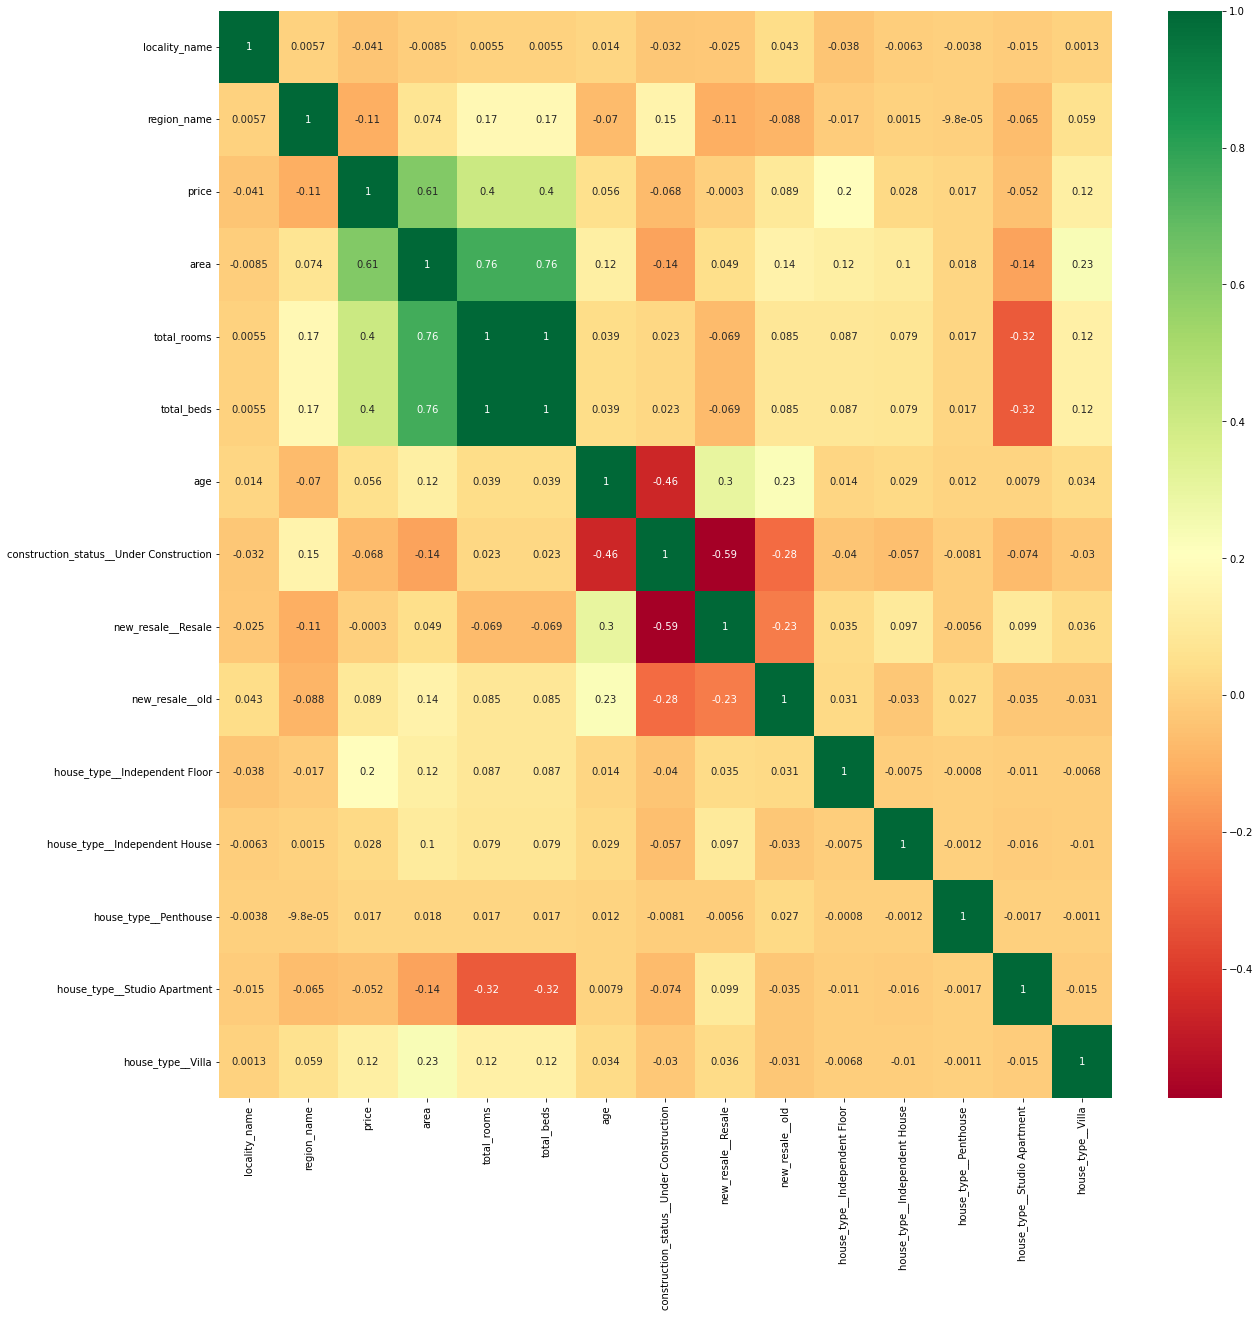

In [127]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = df_model.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_model[top_corr_features].corr(),annot=True,cmap="RdYlGn")

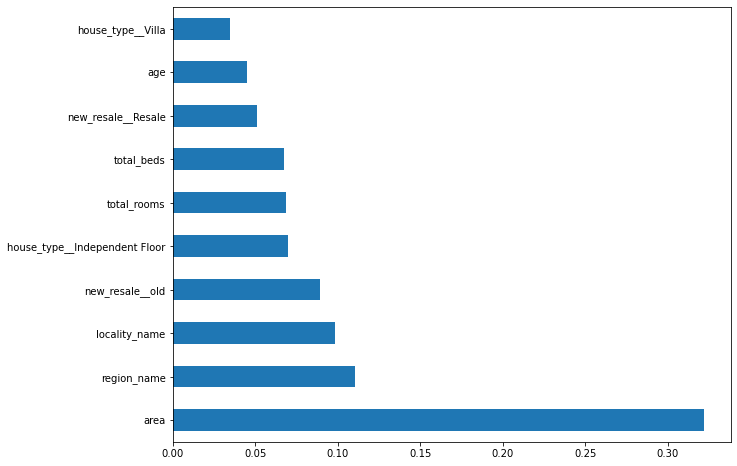

In [128]:
X = df_model.drop('price',axis=1)
y = df_model['price']
  
model = ExtraTreesRegressor()
model.fit(X,y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,8))
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [129]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 123)
  
# Instantiation
xgb_base_model = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)
  
# Fitting the model
xgb_base_model.fit(train_X, train_y)
  
# Predict the model
pred = xgb_base_model.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

RMSE :  1.357660


In [130]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6, 10],
        'min_child_weight': [1, 3],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 300],
        'objective': ['reg:squarederror']
    }

    xgb_model =  xg.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 3,
                           n_jobs = -1,
                           verbose = 2)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [79]:
# hyperParameterTuning(train_X, train_y)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [131]:
xgb_model = xg.XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree =0.5,
        learning_rate = 0.1,
        max_depth = 20,
        min_child_weight = 3,
        n_estimators = 1000,
        subsample =  0.5)

%time xgb_model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(test_X, test_y)], verbose=False)

y_pred_xgb = xgb_model.predict(test_X)

mae_xgb = mean_absolute_error(test_y, y_pred_xgb)

print("MAE: ", mae_xgb)

Wall time: 5.23 s
MAE:  0.23641487937841957


Text(0, 0.5, 'pred_y')

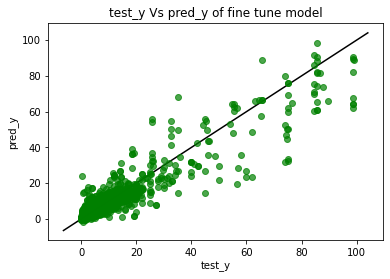

In [132]:
fig, ax = plt.subplots()
ax.scatter(test_y,y_pred_xgb,alpha=0.7,color='g')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', zorder=0)
ax.title.set_text('test_y Vs pred_y of fine tune model')
ax.set_xlabel('test_y')
ax.set_ylabel('pred_y')


Text(0, 0.5, 'pred_y')

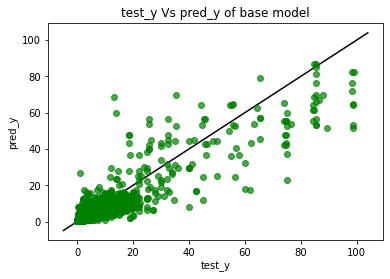

In [133]:
fig, ax = plt.subplots()
ax.scatter(test_y,pred,alpha=0.7,color='g')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', zorder=0)
ax.title.set_text('test_y Vs pred_y of base model')
ax.set_xlabel('test_y')
ax.set_ylabel('pred_y')

In [135]:
from sklearn.model_selection import cross_val_score

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# evaluate model
scores = cross_val_score(xgb_base_model, X, y , scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scores_bm = cross_val_score(xgb_model, X, y , scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = abs(scores)
scores_bm = abs(scores_bm)
print('Mean RMSE xgb base model: %.3f (%.3f)' % (scores.mean(), scores.std()) )
print('Mean RMSE xgb best hyperparameter tuned model: %.3f (%.3f)' % (scores_bm.mean(), scores_bm.std()) )

Mean RMSE xgb base model: 1.324 (0.075)
Mean RMSE xgb best hyperparameter tuned model: 1.101 (0.073)
